<a href="https://colab.research.google.com/github/gitpacho/solar-cell-simulation/blob/main/Heterojuntion_Simulation_(InGaN_Si).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contents

Libreries -- Constant values -- Solar Spectrum

1.   InGaN properties
2.   Silicon properties
3.   Basic Functions for simulate J vs V behaviour
   * Basic functions
   * Basic simulation
   * Characteristic values
4.   SIMULATIONS (varying thickness and stoichiometry)
   * J vs V behaviour
   * P vs V behaviour
   * Simulation Pmpp (Max Power Point)
   * Jsc, Voc, FF, eff results
   * Other results. Varying the doping of the Silicon

# **Libreries  --  Constant values -- Solar Spectrum**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
from scipy.interpolate import interp1d

Kb = 8.6 * 10  ** (-5)           # eV/K
q = 1.602 * 10 ** (-19)          # cm
T = 300                                # T
eps_0 = (8.85 * 10 ** -12) / 10000     # C^2 / (N*cm^2)
c = (3 * 10 ** 8) * 10 ** 9            # nm/s
h = 4.135667731 * 10 ** (-15)          # ev*s
Ref, Trans = 0.1, 1

#Download the solar spectrum
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1neclBSg-ZIvyGf68ZDJ-ED5rOhFgeHjr' -O 'espectro.csv' 
data = pd.read_csv('espectro.csv', header=0, delimiter=';', decimal = ",")
df = pd.DataFrame(data)

#We choose the AM1.5G spectrum
lamb  = np.array(df.loc[(df['Wvlgth nm'] <= 1107.0), 'Wvlgth nm'])  # nm
I_AM15  = np.array(df.loc[(df['Wvlgth nm'] <= 1107.0), 'Global tilt  W*m-2*nm-1'])
photon_flux = I_AM15 * lamb / (q * 1240) / 10000   # 1 / (cm² * nm)

#Total radiation in the material
I_AM15_  = np.array(df['Global tilt  W*m-2*nm-1'])
P_inc = (integrate.simps(I_AM15_) / 10000) * 1000   # mW / cm²     # P_inc = 100

--2021-03-25 18:21:26--  https://docs.google.com/uc?export=download&id=1neclBSg-ZIvyGf68ZDJ-ED5rOhFgeHjr
Resolving docs.google.com (docs.google.com)... 108.177.98.138, 108.177.98.113, 108.177.98.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.98.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v0um8sstto03kaeuna1569n0aelelv36/1616696475000/14095355447248079684/*/1neclBSg-ZIvyGf68ZDJ-ED5rOhFgeHjr?e=download [following]
--2021-03-25 18:21:26--  https://doc-0c-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v0um8sstto03kaeuna1569n0aelelv36/1616696475000/14095355447248079684/*/1neclBSg-ZIvyGf68ZDJ-ED5rOhFgeHjr?e=download
Resolving doc-0c-3s-docs.googleusercontent.com (doc-0c-3s-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0c-3s-docs.googleusercontent.com (doc-0c-3s-d

#1) InGaN properties

In [2]:
Eg_InN,  Eg_GaN  = 0.77,              3.42
Per_InN, Per_GaN = 15.3,              8.9              #ATLAS
Nc_InN,  Nc_GaN  = 0.9 * 10 ** 18,    2.3 * 10 ** 18
Nv_InN,  Nv_GaN  = 5.3 * 10 ** 19,    1.8 * 10 ** 19
Dn_InN,  Dn_GaN  = 80,                39 
Dp_InN,  Dp_GaN  = 8,                 0.75
taon_InN, Taon_GaN = 1 * 10 ** -9,     0.1 * 10 ** -9    #   10.1016/j.solmat.2009.11.010, (0.1063/1.121581 y #10.1016/S0038-1101(99)00227-0 )
taop_InN, Taop_GaN = 5.4* 10 ** -9,     7 * 10 ** -9     #   10.1063/1.2133892,    #10.1016/S0038-1101(99)00227-0 
def DOS(m): 
    m0 = 9.10938291 * 10 ** -31
    k = Kb * q
    hp = h * q
    return 2 * (2 * np.pi * m * m0 * k * T / (hp ** 2)) ** 1.5 / 1000000
def Difusivity(mob): return (Kb * T) * mob
def intrinsic(Nc, Nv, Eg): return (Nc * Nv) ** 0.5 * np.exp(- Eg / (2 * Kb * T))
def Diffusion_Length(D,t): return (D * t) ** 0.5
def EgInGaN(X): return X * Eg_InN + (1 - X) * Eg_GaN - 1.43 * X * (1 - X)
def electron_effective_mass(X): return 0.12 * X + 0.2 * (1 - X)  #atlas y hindawui
def hole_effective_mass(X): return 0.17 * X + 1 * (1 - X)  #atlas y hindawui
def chiInGaN(x, E): return 4.1 + 0.7 * (3.4 - E)
def PermInGaN(x): return Per_InN * x + Per_GaN * (1 - x)
def electron_lifetime_InGaN(X): return taon_InN * X + Taon_GaN * (1-X) 
def hole_lifetime_InGaN(X): return taop_InN * X + Taop_GaN * (1-X) 

#OPTIC ABSORTION
x_lab = [1, 0.83, 0.69, 0.57, 0.5, 0] 
a = [0.69642, 0.66796, 0.58108, 0.60946, 0.51672, 3.52517]
b = [0.46055, 0.68886, 0.66902, 0.62182, 0.46836, -0.65710]
A1, A2, A3, A4, A5 = np.polyfit(x_lab, a, 4)
B1, B2, B3, B4, B5 = np.polyfit(x_lab, b, 4)
def cte_a(X): return A1 * X ** 4 + A2 * X ** 3 + A3 * X ** 2 + A4 * X + A5
def cte_b(X): return B1 * X ** 4 + B2 * X ** 3 + B3 * X ** 2 + B4 * X + B5
def optical_absorption(X):
    A = cte_a(X) * ((1240/lamb) - EgInGaN(X) )
    B = cte_b(X) * ((1240/lamb) - EgInGaN(X) ) ** 2
    C = A + B
    C[np.where(C < 0)] = 0 
    return (10 ** 5) * (C) ** 0.5 
x_values = np.array([0, 0.2, 0.5, 0.8, 1])
mmax = np.array([1460.7, 684.2, 758.1, 1252.7, 3138.4])
mmin = np.array([295,    386.4, 456.4, 644.3,  774])
cte_values = np.array([0.66, 1.37, 1.04, 0.82, 0.68])
C1, C2, C3, C4, C5 = np.polyfit(x_values, mmax, 4)
D1, D2, D3, D4, D5 = np.polyfit(x_values, mmin, 4)
E1, E2, E3, E4, E5 = np.polyfit(x_values, cte_values, 4)
def mov_max(X): return C1 * X ** 4 + C2 * X ** 3 + C3 * X ** 2 + C4 * X + C5
def mov_min(X): return D1 * X ** 4 + D2 * X ** 3 + D3 * X ** 2 + D4 * X + D5
def gamma(X): return E1 * X ** 4 + E2 * X ** 3 + E3 * X ** 2 + E4 * X + E5
def electron_mobility(X, N): 
    DEN = 1 + ((N / (1 * 10 ** 17)) ** gamma(X))
    return mov_min(X) + ( (mov_max(X) - mov_min(X)) / DEN)
def hole_mobility(X, N):
    DENInN = 1 + ((N / (3 * 10 ** 17)) ** 2)
    DENGaN = 1 + ((N / (3 * 10 ** 17)) ** 2)
    MOVInN = 3 + ( (340 - 3) / DENInN)
    MOVGaN = 3 + ( (170 - 3) / DENGaN)
    return MOVInN * X + MOVGaN * (1 - X)

def IGN_PROPERTIES(N_IGN_n, conc_n):
    Eg_IGN_n    =  EgInGaN(conc_n)
    chi_IGN_n   =  chiInGaN(conc_n, Eg_IGN_n)
    Perm_IGN_n  =  PermInGaN(conc_n)
    me_IGN_n    =  electron_effective_mass(conc_n)
    mh_IGN_n    =  hole_effective_mass(conc_n)
    Nc_IGN_n    =  DOS(me_IGN_n)
    Nv_IGN_n    =  DOS(mh_IGN_n)
    Mp_IGN_n    =  hole_mobility(conc_n, N_IGN_n)  ##########
    Dp_IGN_n    =  Difusivity(Mp_IGN_n)
    tp_IGN_n    =  hole_lifetime_InGaN(conc_n)
    Lp_IGN_n    =  Diffusion_Length(Dp_IGN_n,tp_IGN_n)
    S_IGN_n     =  10 ** 3
    ni_IGN_n    =  intrinsic(Nc_IGN_n, Nv_IGN_n, Eg_IGN_n)
    alpha_IGN_n =  optical_absorption(conc_n)
    return Eg_IGN_n, chi_IGN_n, Perm_IGN_n, Nc_IGN_n, Nv_IGN_n, Dp_IGN_n, tp_IGN_n, Lp_IGN_n, S_IGN_n, ni_IGN_n, alpha_IGN_n


#2) Silicon properties

In [3]:
# Optical absortion
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zjUlU29F_U2REiZPn5N1GkNO3ngdQ4Dq' -O 'OpticalPropertiesOfSilicon.csv'
data = pd.read_csv('OpticalPropertiesOfSilicon.csv', header=0, delimiter=',', decimal = ".")
df = pd.DataFrame(data)
wavelength = np.array(df['wavelength(nm)'])  # nm
alpha = np.array(df['a(/cm)'])         # 1/cm

# Function to interpolate alpha based on lambda
interpolator = interp1d(wavelength, alpha, kind='cubic')
alpha_Si = interpolator(lamb) 

#Carrier lifetimes
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BBXxMXeez77IpLYAtd_U0tXxhpMWxvGm' -O 'taoSi_n.csv'
data = pd.read_csv('taoSi_n.csv', header=0, delimiter=',', decimal = ".")
doping = np.array(data['concentration'])
tao = np.array(data['tao'])
tn_interpolator = interp1d(doping, tao, kind = 'cubic')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VQyaDiSh8CdmsoboJ8m-24CoQ3PyE8S8' -O 'taoSi_p.csv'
data = pd.read_csv('taoSi_p.csv', header=0, delimiter=',', decimal = ".")
doping = np.array(data['concentration'])
tao = np.array(data['tao'])
tp_interpolator = interp1d(doping, tao, kind = 'cubic')

def mobilitySi_n(N): return 68.5 + (1414 - 68.5) / (1 + (N / (9.2 * 10 ** 16)) ** 0.711)   #fosforo
def mobilitySi_p(N): return 44.9 + (470.5 - 44.9) / (1 + (N / (2.23 * 10 ** 17)) ** 0.719) #boro

#Electrical parameters 
Eg_Si   =  1.12                                  # Band Gap
chi_Si  =  4.05                                  # Electron Affinity
Perm_Si =  11.7                                  # Permittivity
me_Si   =  1.08                                  # Effective mass of electrons
mh_Si   =  0.811                                 # Effective mass of holes
Nc_Si   =  DOS(me_Si)                            # Effective density of states in the conduction band  (Supported by calculations and Fonash)
Nv_Si   =  DOS(mh_Si)                            # Effective density of states in the Valence band  (Supported by calculations and Fonash)
N_Si_n  =  10 ** 16                              # N Dopping (1/cm³)
N_Si_p  =  10 ** 16                              # P Dopping (1/cm³)
ni_Si   =  intrinsic(Nc_Si, Nv_Si, Eg_Si)        # intrinsic density
mobSi_n =  mobilitySi_n(N_Si_n)                  # Electron Mobility  ~ 1400  cm² / (V*s)
mobSi_p =  mobilitySi_p(N_Si_n)                  # Hole Mobility      ~ 450   cm² / (V*s)
Dn_Si   =  Difusivity(mobSi_n)                   # Difusivity of electrons
Dp_Si   =  Difusivity(mobSi_p)                   # Difusivity of holes
taon_Si =  tn_interpolator(N_Si_n)               # Electron lifetime  
taop_Si =  tp_interpolator(N_Si_n)               # Hole lifetime
Ln_Si   =  Diffusion_Length(Dn_Si , taon_Si)     # Electron Diffusion_Length
Lp_Si   =  Diffusion_Length(Dp_Si , taop_Si)     # Hole Diffusion_Length
Sn_Si   =  10 ** 7                               # Electron surface recombination
Sp_Si   =  10 ** 7                               # Holes surface recombination


# Finally we encapsulate the properties (for p material)
def SILICON_PROPERTIES(N_Si_p):
    me_Si_p    =  1.08
    mh_Si_p    =  0.811
    Eg_Si_p    =  1.12
    chi_Si_p   =  4.05
    Perm_Si_p  =  11.7
    Nc_Si_p    =  DOS(me_Si_p)
    Nv_Si_p    =  DOS(mh_Si_p)
    Mn_Si_p    =  mobilitySi_n(N_Si_p)   ##########
    Dn_Si_p    =  Difusivity(Mn_Si_p)
    tn_Si_p    =  tn_interpolator(N_Si_p)
    Ln_Si_p    =  Diffusion_Length(Dn_Si_p , tn_Si_p)
    S_Si_p     =  10 ** 3
    ni_Si_p    =  intrinsic(Nc_Si_p, Nv_Si_p, Eg_Si_p)
    alpha_Si_p =  alpha_Si
    return Eg_Si_p, chi_Si_p, Perm_Si_p, Nc_Si_p, Nv_Si_p, Dn_Si_p, tn_Si_p, Ln_Si_p, S_Si_p, ni_Si_p, alpha_Si_p

--2021-03-25 18:21:27--  https://docs.google.com/uc?export=download&id=1zjUlU29F_U2REiZPn5N1GkNO3ngdQ4Dq
Resolving docs.google.com (docs.google.com)... 74.125.142.100, 74.125.142.113, 74.125.142.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hsemou2ts7jvi7j9joihoa7qrievf1b5/1616696475000/14095355447248079684/*/1zjUlU29F_U2REiZPn5N1GkNO3ngdQ4Dq?e=download [following]
--2021-03-25 18:21:27--  https://doc-0k-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hsemou2ts7jvi7j9joihoa7qrievf1b5/1616696475000/14095355447248079684/*/1zjUlU29F_U2REiZPn5N1GkNO3ngdQ4Dq?e=download
Resolving doc-0k-3s-docs.googleusercontent.com (doc-0k-3s-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0k-3s-docs.googleusercontent.com (doc-0k-3s-d

#3) Basic Functions for simulate J vs V behaviour


## 3.1) Basic functions

Functions for Calculate the photoelectric response of a single cell

In [4]:
def Vbi(Egn, Egp, chin, chip, Nd, Na, Ncn, Ncp, Nvn, Nvp, nin, nip):  # Built-in Potential
    delta_gap = abs(Egn - Egp)
    delta_ec  = abs(chip - chin)
    delta_ev  = delta_gap - delta_ec
    A = (delta_ec - delta_ev) / 2
    B = Kb * T * np.log(Nd * Na / (nin * nip))
    C = 0.5 * Kb * T * np.log(Ncp * Nvn / (Ncn * Nvp))
    return A + B + C
def region(a, b, epsn, epsp, Nd, Na, Vbi, V):                         # Depletion region
    A = 2 * epsp * epsn * eps_0 * a * (Vbi - V) * 100
    B = q * b * (epsn * Nd + epsp * Na)
    return (A / B) ** 0.5
def pn0(ni, N): return (ni ** 2 / N)

#Currents densities

def j0pn(D, pn0, L, s, w, x):               
    A = q * D * pn0 / L
    B = s * L / D
    ang = (w - x) / L
    return A * (B * np.cosh(ang) + np.sinh(ang) ) / (B * np.sinh(ang) + np.cosh(ang))
def j00(xn, xp, nin, nip, Lp, Ln, Dp, Dn):   
    taop = (Lp ** 2) / Dp
    taon = (Ln ** 2) / Dn
    return q * ( (xn * nin / taop) + (xp * nip / taon))
def jdark(j01, j02, j00, v):                    #A/cm^2
    j0 = j01 + j02
    Jnight = (j0 * (np.exp(v / (Kb * T)) - 1)) + (j00 * (np.exp(v / (2 * Kb * T)) - 1))
    return Jnight
def djn(sn, Ln, Dn, wp, xp, alpha2, wn, alpha1, Ref, Trans):
    cte1 = sn * Ln / Dn
    cte2 = wp - xp
    angulo = (wp - xp) / Ln
    A = q * photon_flux * (1 - Ref) * Trans * alpha2 * Ln
    B = np.exp(-(alpha1 * wn + alpha2 * xp))
    C = ((alpha2 ** 2) * (Ln ** 2)) - 1
    D = alpha2 * Ln
    E = cte1 * (np.cosh(angulo) - np.exp( - alpha2 * cte2 ) )
    F = np.sinh(angulo) 
    G = alpha2 * Ln * np.exp(- alpha2 * cte2)
    H = cte1 * np.sinh(angulo)
    I = np.cosh(angulo)
    return (A * B / C) * (D - ( (E + F + G ) / (H + I) ))
def djp(sp, Lp, Dp, wn, xn, alpha1, Ref, Trans):
    cte1 = sp * Lp / Dp
    cte2 = wn - xn
    angulo = (wn - xn) / Lp    
    A = q * photon_flux * (1 - Ref) * Trans * alpha1 * Lp
    B = ((alpha1 ** 2) * (Lp ** 2) ) - 1
    C = cte1 + (alpha1 * Lp)
    D = np.exp(- (alpha1 * cte2))
    E = ( cte1 * np.cosh(angulo) ) + np.sinh(angulo)
    F = ( cte1 * np.sinh(angulo) ) + np.cosh(angulo)
    G = alpha1 * Lp * np.exp( - alpha1 * cte2)
    return (A / B) *  ( ((C - D * E) / F) - G)
def djscr(xn, xp, wn, alpha1, alpha2 , Ref, Trans):
    A = q * photon_flux * (1 - Ref) * Trans * np.exp( - alpha1 * (wn - xn))
    B = 1 - np.exp( - alpha1 * xn)
    C = np.exp( - alpha1 * xn) * (1 - np.exp(- alpha2 * xp))
    return A * (B + C)

## 3.2) Basic simulation

* Function for simulate J vs V behavior.
* We call this function as base_simulation.

In [5]:
#  We must properly set the numbers of V_list values ​​to avoid excess operations
V_list = np.linspace(0, 1, 201)  

def base_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p):

    # DATA CONTAINERS
    J_list = []
    Pot_list = []
    x_n_list = []
    x_p_list = []

    for V in V_list:

        #POPERTIES OF MATERIALS
        Eg_IGN_n, chi_IGN_n, Perm_IGN_n, Nc_IGN_n, Nv_IGN_n, Dp_IGN_n, tp_IGN_n, Lp_IGN_n, S_IGN_n, ni_IGN_n, alpha_IGN_n = IGN_PROPERTIES(N_IGN_n = N_IGN_n, conc_n = conc_n)
        Eg_Si_p, chi_Si_p, Perm_Si_p, Nc_Si_p, Nv_Si_p, Dn_Si_p, tn_Si_p, Ln_Si_p, S_Si_p, ni_Si_p, alpha_Si_p = SILICON_PROPERTIES(N_Si_p = N_Si_p)    
        
        #CORRESPONDENCES WITH THE MODEL EQUATIONS
        Eg_n,  Eg_p  = Eg_IGN_n,        Eg_Si_p
        chi_n, chi_p = chi_IGN_n,       chi_Si_p
        N_d,   N_a   = N_IGN_n,         N_Si_p
        Nc_n,  Nc_p  = Nc_IGN_n,        Nc_Si_p
        Nv_n,  Nv_p  = Nv_IGN_n,        Nv_Si_p
        eps_n, eps_p = Perm_IGN_n,      Perm_Si_p
        D_p,   D_n   = Dp_IGN_n,        Dn_Si_p   #Dp_IGN_n #
        L_p,   L_n   = Lp_IGN_n,        Ln_Si_p   #Lp_IGN_n #
        s_p,   s_n   = S_IGN_n ,        S_Si_p
        w_n,   w_p   = w_IGN_n,         w_Si_p 
        alpha_1 = alpha_IGN_n
        alpha_2 = alpha_Si_p
        ni_n = ni_IGN_n
        ni_p = ni_Si_p

        #CALCULATIONS ------------------------------------------------------------------- 

        V_bi = Vbi(Eg_n, Eg_p, chi_n, chi_p, N_d, N_a, Nc_n, Nc_p, Nv_n, Nv_p, ni_n, ni_p)
        x_n = region(N_a, N_d, eps_n, eps_p, N_d, N_a, V_bi, V )
        x_p = region(N_d, N_a, eps_n, eps_p, N_d, N_a, V_bi, V )

        if x_n > w_n:  # Condition in case the depletion region exceeds the width of the material
            x_n = w_n
            x_p = w_n * (N_d / N_a)
        x_n_list.append(x_n)
        x_p_list.append(x_p)

        n_0    =  pn0(ni_p, N_a)    #p
        p_0    =  pn0(ni_n, N_d)    #n
        j0_n   =  j0pn(D_n, n_0, L_n, s_n, w_p, x_p)
        j0_p   =  j0pn(D_p, p_0, L_p, s_p, w_n, x_n)
        j_00   =  j00(x_n, x_p, ni_n, ni_p, L_p, L_n, D_p, D_n)
        j_dark =  jdark(j0_n, j0_p, j_00, V)
        dj_n   =  djn(s_n, L_n, D_n, w_p, x_p, alpha_2, w_n, alpha_1, Ref, Trans)   
        dj_p   =  djp(s_p, L_p, D_p, w_n, x_n, alpha_1, Ref, Trans)
        dj_scr =  djscr(x_n, x_p, w_n, alpha_1, alpha_2 , Ref, Trans)
        j_ph   =  integrate.simps(dj_p + dj_n + dj_scr)
        j_cell =  j_ph - j_dark

        J_list.append(j_cell)
        Pot_list.append(V * j_cell)

    return J_list, Pot_list, x_n_list, x_p_list

## 3.3) Characteristic values
We use a helper function called 'CHARACTERISTICS_VALUES' for get Voc, Jsc, FF and efficiency.

In [6]:
def CHARACTERISTICS_VALUES(J_list, Pot_list, V_list):
    Positives = [x for x in J_list if x > 0]
    Position = len(Positives)
    x1, x2 = V_list[Position - 1], V_list[Position]
    y1, y2 = J_list[Position - 1], J_list[Position]
    m = (y2 - y1) / (x2 - x1)
    V_oc = (- y1 / m) + x1
    J_sc = J_list[0] * 1000
    Pot_list_ = [x for x in Pot_list if str(x) != 'nan']
    Position = int(np.where(Pot_list_ == np.amax(Pot_list_))[0])
    V_mpp = V_list[Position] 
    J_mpp = J_list[Position] * 1000
    x_n_opt = x_n_list[Position]  #Depletion region
    x_p_opt = x_p_list[Position]  #Depletion region
    FF = ((J_mpp * V_mpp) / (J_sc * V_oc)) * 100
    Eff = (J_mpp * V_mpp) / 100
    return V_oc, J_sc, FF, Eff, x_n_opt, x_p_opt

# 4) SIMULATIONS (varying thickness and stoichiometry)


-------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------


## 4.1) J vs V behaviour


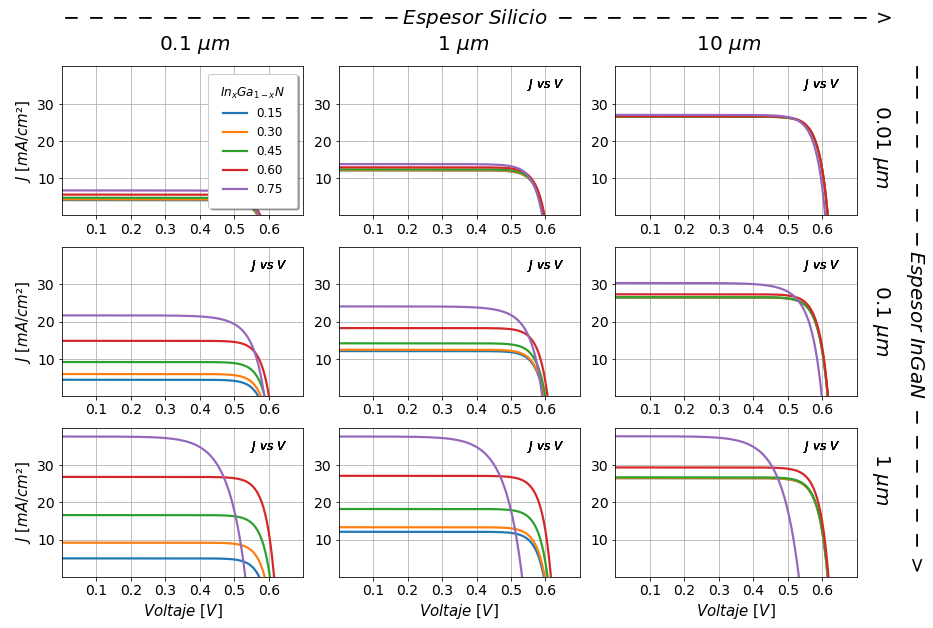

In [7]:
#Libreries and values of visualization
from itertools import product
import matplotlib as mpl
params = {'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.title_fontsize' : 12}
mpl.rcParams.update(params)
labels_size = 15

#Function to graph
def individual_graph_J(ax):
    for i, j in enumerate(conc_n_list):
      ax.plot(V_list, np.array(J_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2.2)
      ax.set_xlim(0, 0.7)
      ax.set_ylim(0, 40)
      ax.text(0.6, 35, r"$J\ vs\ V$", ha="center", va="center", size = 12)
      ax.grid()
      ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
      ax.set_yticks([10,20,30])        
      plt.tight_layout()

#SIMULATION
N_IGN_n = 10 ** 14  #we can change for 10 ** 17 and observe the behaviour
N_Si_p = 10 ** 16
w_IGN_n_list    =  np.array([0.1, 1, 10]) * 10 ** -5
w_Si_p_list    =  np.array([1, 10, 100]) * 10 ** -5
conc_n_list = np.linspace(0.15 ,0.75, 5)  
cross_product = product(w_IGN_n_list, w_Si_p_list)
ubication = list(product([0,1,2], [0,1,2]))

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12, 8)
cont = 0
for w_IGN_n, w_Si_p in cross_product:
    J_lists, Pot_lists = [], []
    Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
    for conc_n in conc_n_list:
        J_list, Pot_list, x_n_list, x_p_list = base_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
        J_lists.append(J_list)
        Pot_lists.append(Pot_list)
        Voc, Jsc, FF, Eff, xn_opt, xp_opt = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
        Jsc_list.append(Jsc)
        Voc_list.append(Voc)
        FF_list.append(FF)
        Eff_list.append(Eff)
    a, b = ubication[cont]    
    individual_graph_J(ax[a, b]) 
    if cont == 0: ax[a,b].legend(title = r'$In_{x}Ga_{1-x}N$', fontsize = 12, fancybox=True, framealpha=1, shadow=True, borderpad=1, loc = 'right')
    if cont in [6, 7, 8]: ax[a,b].set_xlabel(r'$Voltaje\ [V]$', size = labels_size)
    if cont in [0,3,6]: ax[a,b].set_ylabel(r'$J\ [mA/cm²]$', size = labels_size) 
    cont += 1

plt.text(0.87, 70, r"$-------- Espesor \ InGaN \ ------>$", ha="center", va="center", rotation=270, size = 20)
plt.text(0.77, 73, r"${}\ \mu m {} {}\ \mu m {} {}\ \mu m $".format(0.01,'\ '* 15 ,0.1, '\ '* 15 ,1), ha="center", va="center", rotation=270, size = 20)
plt.text(-0.48, 150, r"$\ \ \ \ \ \ \ \ -------------- Espesor \ Silicio \ ------------->    $", ha="center", va="center", size = 20)
plt.text(-0.45, 143, r"${}\ \mu m {} {}\ \mu m {} {}\ \mu m $".format(0.1,'\ '* 32 , 1, '\ '* 32 ,10), ha="center", va="center", size = 20)
plt.show()

## 4.2) P vs V behaviour



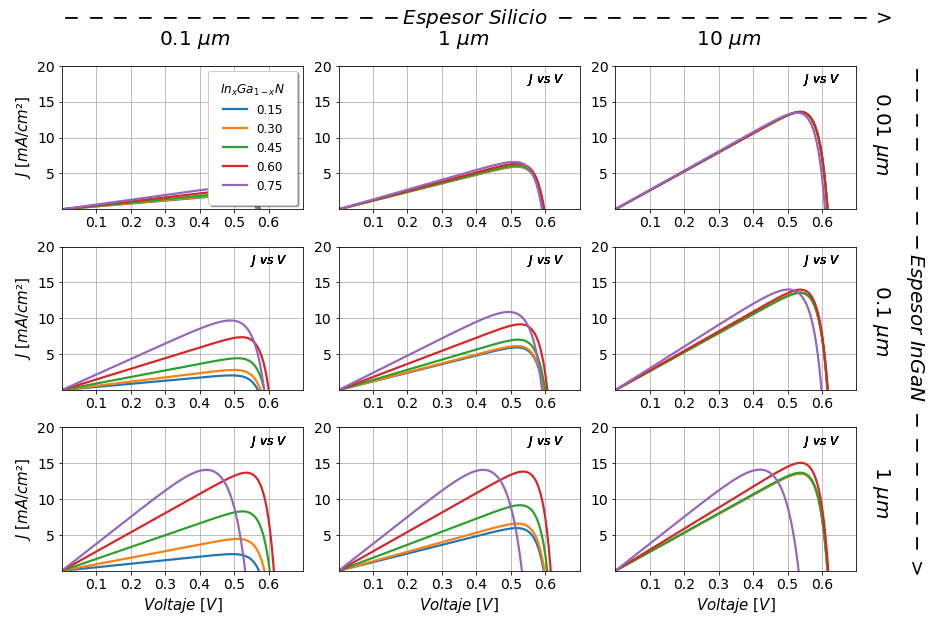

In [8]:
#Function to graph
def individual_graph_P(ax):
    for i, j in enumerate(conc_n_list):
      ax.plot(V_list, np.array(Pot_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2.2)
      ax.set_xlim(0, 0.7)
      ax.set_ylim(0, 20)
      ax.text(0.6, 18, r"$J\ vs\ V$", ha="center", va="center", size = 12)
      ax.grid()
      ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
      ax.set_yticks([5, 10, 15, 20])        
      plt.tight_layout()

#SIMULATION

N_IGN_n = 10 ** 14
N_Si_p = 10 ** 16
w_IGN_n_list    =  np.array([0.1, 1, 10]) * 10 ** -5
w_Si_p_list    =  np.array([1, 10, 100]) * 10 ** -5
conc_n_list = np.linspace(0.15 ,0.75, 5)  
cross_product = product(w_IGN_n_list, w_Si_p_list)
ubication = list(product([0,1,2], [0,1,2]))

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12, 8)
cont = 0
for w_IGN_n, w_Si_p in cross_product:
    J_lists, Pot_lists = [], []
    Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
    for conc_n in conc_n_list:
        J_list, Pot_list,x_n_list, x_p_list = base_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
        J_lists.append(J_list)
        Pot_lists.append(Pot_list)
        Voc, Jsc, FF, Eff, xn_opt, xp_opt = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
        Jsc_list.append(Jsc)
        Voc_list.append(Voc)
        FF_list.append(FF)
        Eff_list.append(Eff)
    a, b = ubication[cont]    
    individual_graph_P(ax[a, b]) #V_list, np.array(J_lists[i]) * 10 ** 3)
    if cont == 0: ax[a,b].legend(title = r'$In_{x}Ga_{1-x}N$', fontsize = 12, fancybox=True, framealpha=1, shadow=True, borderpad=1, loc = 'right')
    if cont in [6, 7, 8]: ax[a,b].set_xlabel(r'$Voltaje\ [V]$', size = labels_size)
    if cont in [0,3,6]: ax[a,b].set_ylabel(r'$J\ [mA/cm²]$', size = labels_size) 
    cont += 1

plt.text(0.87, 35, r"$-------- Espesor \ InGaN \ ------>$", ha="center", va="center", rotation=270, size = 20)
plt.text(0.77, 37, r"${}\ \mu m {} {}\ \mu m {} {}\ \mu m $".format(0.01,'\ '* 17 ,0.1, '\ '* 17 ,1), ha="center", va="center", rotation=270, size = 20)
plt.text(-0.48, 77, r"$\ \ \ \ \ \ \ \ -------------- Espesor \ Silicio \ ------------->    $", ha="center", va="center", size = 20)
plt.text(-0.45, 74, r"${}\ \mu m {} {}\ \mu m {} {}\ \mu m $".format(0.1,'\ '* 32 , 1, '\ '* 32 ,10), ha="center", va="center", size = 20)
plt.show()

## 4.3) Simulation Pmpp (Max Power Point) 

The results are represented on color maps as a function of the thickness of the Silicon and InGaN


In [9]:
# Time meter and image parameters
%%time
params = {'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.title_fontsize' : 12}
mpl.rcParams.update(params)
pixels = 5                                                 # Pixels of the image. As this value increases, the simulation time also increases.

# Containers
Pmpp_data = []
Voc_data  = []
Jsc_data  = []

#Parameters
N_IGN_n       =  1 * 10 ** 14                                    # InGaN Dopping
N_Si_p        =  1 * 10 ** 16                                    # Si Dopping
w_IGN_n_list  =  np.logspace(-6, -3, pixels)                     # InGaN thicknesses
w_Si_p_list   =  np.logspace(-4, np.log10(0.05), pixels)         # Si thicknesses
cross_product =  list(product(w_IGN_n_list, w_Si_p_list))
conc_n_list   =  [0,0.1, 0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9, 1]   #stoichiometries

#SIMULATION
plt.figure()
cont = 1
for conc_n in conc_n_list:
    J_lists, Pot_lists = [], []
    Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
    Pmpp_list = []

    for w_IGN_n, w_Si_p in cross_product:
        J_list, Pot_list, x_n_list, x_p_list = base_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
        Pot_list = np.array(Pot_list)
        Pmpp_list.append(np.amax(Pot_list[Pot_list >= 0]))
        J_lists.append(J_list)
        Pot_lists.append(Pot_list)
        Voc, Jsc, FF, Eff, xn_opt, xp_opt = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
        Jsc_list.append(Jsc)
        Voc_list.append(Voc)
        FF_list.append(FF)
        Eff_list.append(Eff)
    Pmpp_results = (np.array(Pmpp_list) * 1000).reshape(pixels, -1)
    Pmpp_data.append(Pmpp_results)
    Voc_results = (np.array(Voc_list)).reshape(pixels, -1)
    Voc_data.append(Voc_results)
    Jsc_results = (np.array(Jsc_list)).reshape(pixels, -1)
    Jsc_data.append(Jsc_results)
    print('Pot:', np.amax(Pmpp_results))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Pot: 19.169742342723964
Pot: 19.169832186584728
Pot: 19.170720929204897
Pot: 19.17488939236907
Pot: 19.18703494189617
Pot: 19.218131793652013
Pot: 19.236279207033892
Pot: 19.133598850561725
Pot: 16.596082849485786
Pot: 11.534505969598069
Pot: 7.631014100697817
CPU times: user 28.5 s, sys: 9.6 ms, total: 28.5 s
Wall time: 28.5 s


<Figure size 432x288 with 0 Axes>

0.07631014100697817

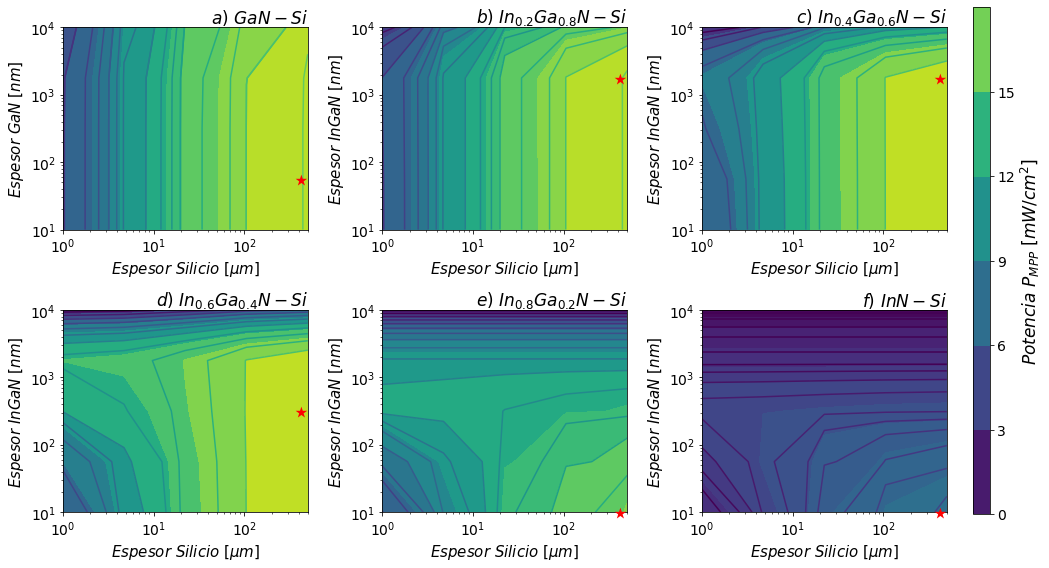

In [10]:
# Graphs of the previous simulations

#aditional lists, for label the graphs
list_1 = [0.1, 0.2,0.3, 0.4, 0.5, 0.6,0.7, 0.8, 0.9]
list_2 =  list_1[::-1]
list_3 = ['a)\ ','b)\ ', 'b)\ ', 'c)\ ','c)\ ', 'd)\ ','d)\ ', 'e)\ ', 'e)\ ','e)\ ']
Names = ['a)\ GaN-Si']
cont = 0
for i,j in zip(list_1, list_2):
  Names.append(list_3[cont] + 'In_{' + str(i) + '}Ga_{' + str(j) + '}N-Si')
  cont += 1
Names.append('f)\ InN-Si')

# Image parameters
labelsize = 15
min = 0
max= 21
levels = np.linspace(min, 18, 7)
lines = 15
conc_n_list = np.linspace(0,1, 6)
lim = 16
lim2 = 19

#Colormaps results visualization
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches((12, 8))
i = 0
for ax in axes.flat:
    if i == 0:
          imag = ax.contour(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 7, Pmpp_data[i], lines,levels = levels, vmin = min + 3, vmax = max + 3)#, cmap = set_color)
          imag = ax.contourf(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 7, Pmpp_data[i],10,levels = levels, vmin = min, vmax = max)#, cmap = set_color)
          plt.tight_layout()
    im = ax.contour(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 7, Pmpp_data[i], lines, vmin = min + 3, vmax = max + 3)#, cmap = set_color)
    im = ax.contourf(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 7, Pmpp_data[i],10,  vmin = min, vmax = max)#, cmap = set_color)
    ax.set_xscale('log')
    ax.set_yscale('log')    
    ax.text(w_Si_p_list[-1] * 10 ** 4, w_IGN_n_list[-1] * 10 ** 7, s = r'${}$'.format(Names[i]), fontsize = 17, ha = 'right', va = 'bottom')
    plt.tight_layout()
    pos = np.where(Pmpp_data[i] == np.amax(Pmpp_data[i]))
    a = pos[0][0]
    b = pos[1][0]
    c = '{:.2f}'.format(Pmpp_data[i][a][b])
    ax.text(x = w_Si_p_list[b] * 10**4 , y = w_IGN_n_list[a] * 10 ** 7, s = r'$\star $', fontsize = 30, ha = 'right', va = 'center', color = 'r')
    mask = (Pmpp_data[i] > lim) & (Pmpp_data[i] < lim2)
    listado = np.where(mask)
    y = listado[0]
    x = listado[1]
    ax.set_xlabel(r'$Espesor\ Silicio\ [\mu m]$', fontsize = labelsize)
    ax.set_ylabel(r'$Espesor\ InGaN\ [nm]$',   fontsize = labelsize)   
    if i == 0:
      ax.set_ylabel(r'$Espesor\ GaN\ [nm]$',   fontsize = labelsize)
    elif i == 5:
      ax.set_ylabel(r'$Espesor\ InN\ [nm]$',   fontsize = labelsize)
    i += 2

fig.tight_layout()
fig.subplots_adjust(right=1.1)
cbar_ax = fig.add_axes([1.13, 0.1, 0.02, 0.88])
cbar = fig.colorbar(imag,extend = 'max', cax=cbar_ax, label='digit value', ticks = [0,3,6,9,12, 15])
cbar.set_label(r"$Potencia\ P_{MPP}\ [mW/cm^{2}]$", size = 17)
np.amax(np.array(Eff_list))

## 4.4) Jsc, Voc, FF, eff results

In [11]:
#functions to graph
def J_V_GRAPH(V_list, J_lists, xlim = 0.7, ylim = 40, label_size = 15, legend_size = 15, title_size = 18, title_legend = r'$In_{X}Ga_{1-x}N$'):
    for i, j in enumerate(conc_n_list):
        if conc_n_list[i] > 0.75:
          plt.plot(V_list, np.array(J_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2, ls = '--')
        else:
          plt.plot(V_list, np.array(J_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2.2)
    plt.title(r'$a)\ Densidad\ de\ corriente$', fontsize = title_size)
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.xlabel(r'$Voltaje\ [V]$', fontsize = label_size)
    plt.ylabel(r'$J\ [mA/cm^{2}]$', fontsize = label_size)
    plt.legend(fontsize = legend_size, loc = 'best', title = title_legend)
    plt.grid('on')
    plt.tight_layout()

def P_V_GRAPH(V_list, Pot_lists, xlim = 0.7, ylim = 20, label_size = 15, legend_size = 15, title_size = 18, title_legend = r'$In_{X}Ga_{1-x}N$'):
    for i, j in enumerate(conc_n_list):
        if conc_n_list[i] > 0.75:
          plt.plot(V_list, np.array(Pot_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2, ls = '--')
        else:
          plt.plot(V_list, np.array(Pot_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2.2)
    plt.title(r'$b)\ Densidad\ de\ potencia$', fontsize = title_size)
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.xlabel(r'$Voltaje\ [V]$', fontsize = label_size)
    plt.ylabel(r'$P\ [mW/cm^{2}]$', fontsize = label_size)
    plt.legend(fontsize = legend_size, loc = 'best', title = title_legend)
    plt.grid('on')
    plt.tight_layout()

def characteristic_graph(conc_n_list, data, title, ylabel, limits, axes_size = 15, title_size = 18):
      plt.plot(conc_n_list, data, lw = 2.5)
      plt.ylim(0)
      plt.ylim(limits[0], limits[1])
      plt.xlim(0.1,0.8)
      plt.ylabel(ylabel = ylabel, fontsize = axes_size)
      plt.title(label = title, fontsize = title_size)
      plt.xlabel(r'$x $', fontsize = axes_size)
      plt.grid()
      plt.axvline(0.7, ls = '--', color = 'r')
      plt.xticks([0, 0.2, 0.4, 0.6, 0.8])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: This figure includes

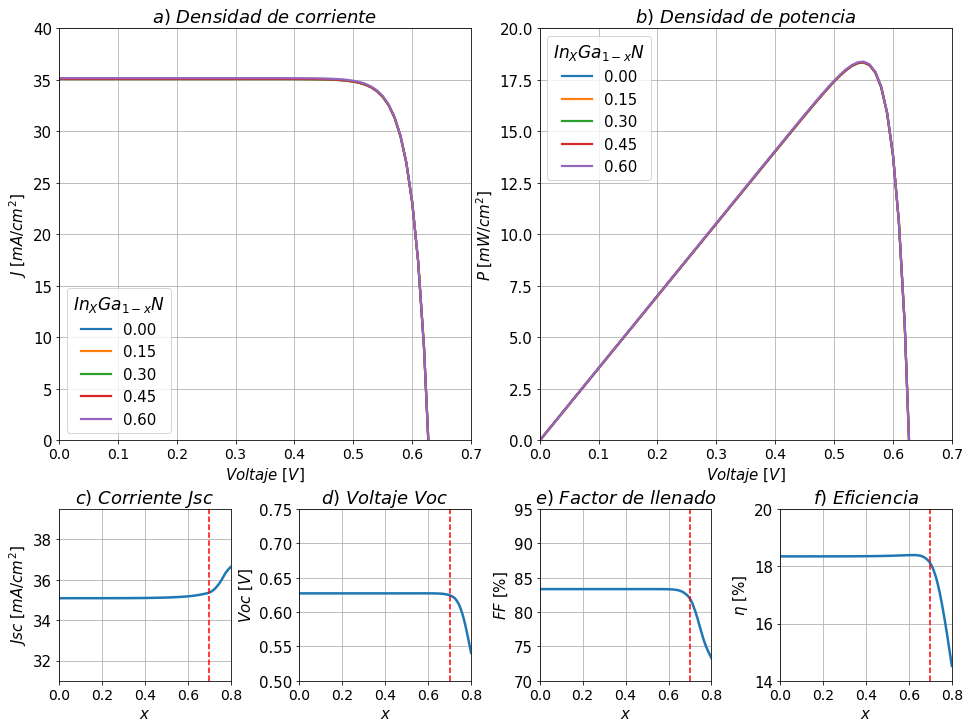

In [12]:
#Simulation
V_list = np.linspace(0, 1, 101)
J_lists, Pot_lists = [], []
Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
N_IGN_n     = 10 ** 14
N_Si_p      = 1 * 10 ** 16
w_IGN_n     = 0.1 * 10 ** - 4
w_Si_p      = 150 * 10 ** - 4
conc_n_list = list(np.linspace(0, 0.6, 5))

for conc_n in conc_n_list:
    J_list, Pot_list,x_n_list, x_p_list = base_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
    J_lists.append(J_list)
    Pot_lists.append(Pot_list)
    Voc, Jsc, FF, Eff, xn_opt, xp_opt = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
    Jsc_list.append(Jsc)
    Voc_list.append(Voc)
    FF_list.append(FF)
    Eff_list.append(Eff)

J_lists_, Pot_lists_ = [], []
Jsc_list_, Voc_list_, FF_list_, Eff_list_ = [], [], [], []
conc_n_list_ = np.linspace(0, 0.8, 100)
for conc_n in conc_n_list_:
    J_list_, Pot_list_, x_n_list_, x_p_list_ = base_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
    J_lists_.append(J_list_)
    Pot_lists_.append(Pot_list_)
    Voc_, Jsc_, FF_, Eff_, xn_opt_, xp_opt_ = CHARACTERISTICS_VALUES(J_list_, Pot_list_, V_list)
    Jsc_list_.append(Jsc_)
    Voc_list_.append(Voc_)
    FF_list_.append(FF_)
    Eff_list_.append(Eff_)

# Graphs
fig = plt.figure(figsize=(16, 12))
title_size = 18
axes_size = 15
params = {'xtick.labelsize': 14, 'ytick.labelsize': 15, 'legend.title_fontsize' : 17}
mpl.rcParams.update(params)
map_label = {(0, 0) : r'$Jsc\ [mA/cm^{2}]$', 
             (0, 1) : r'$Voc\ [V]$',
             (1, 0) : r'$FF\ [\%]$',
             (1, 1) : r'$\eta\ [\%]$'}
map_title = {(0, 0) : r'$c)\ Corriente\ Jsc$', 
             (0, 1) : r'$d)\ Voltaje\ Voc$',
             (1, 0) : r'$e)\ Factor\ de\ llenado$',
             (1, 1) : r'$f)\ Eficiencia$'}
rows = 3
columns = 4
grid = plt.GridSpec(rows, columns, wspace = .4, hspace = .4)
plt.subplot(grid[:2, :2])
J_V_GRAPH(V_list, J_lists)
plt.subplot(grid[:2, 2:])
P_V_GRAPH(V_list, Pot_lists)
plt.subplot(grid[2, 0])
characteristic_graph(conc_n_list_,  Jsc_list_, map_title[(0, 0)], map_label[(0, 0)], (31, 39.5))
plt.subplot(grid[2, 1])
characteristic_graph(conc_n_list_,  Voc_list_, map_title[(0, 1)], map_label[(0, 1)], (0.5, 0.75))
plt.tight_layout()
plt.subplot(grid[2, 2])
characteristic_graph(conc_n_list_,  FF_list_, map_title[(1, 0)], map_label[(1, 0)], (70, 95))
plt.tight_layout()
plt.subplot(grid[2, 3])
characteristic_graph(conc_n_list_,  np.array(Eff_list_) * 100, map_title[(1, 1)], map_label[(1, 1)], (14, 20))
plt.tight_layout()

## 4.5) Other results. Varying the doping of the Silicon

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered

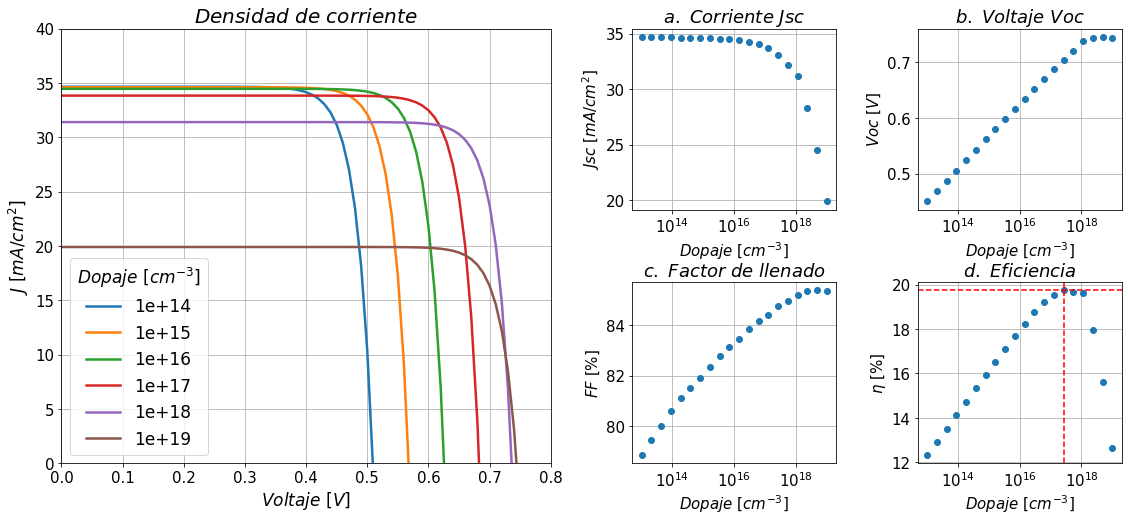

In [13]:
fig = plt.figure(figsize=(19, 8))
title_size = 18
axes_size = 15
params = {'xtick.labelsize': 15, 'ytick.labelsize': 15, 'legend.title_fontsize' : 17}
mpl.rcParams.update(params)

map_label = {(0, 0) : r'$Jsc\ [mA/cm^{2}]$', 
             (0, 1) : r'$Voc\ [V]$',
             (1, 0) : r'$FF\ [\%]$',
             (1, 1) : r'$\eta\ [\%]$'}
map_title = {(0, 0) : r'$a.\ Corriente\ Jsc$', 
             (0, 1) : r'$b.\ Voltaje\ Voc$',
             (1, 0) : r'$c.\ Factor\ de\ llenado$',
             (1, 1) : r'$d.\ Eficiencia$'}
rows = 2
columns = 4
grid = plt.GridSpec(rows, columns, wspace = .4, hspace = .4)


plt.subplot(grid[:, :2])
Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
N_LIST = np.logspace(14, 19, 6)
for N_Si_p in N_LIST:
  w_IGN_n_list    =  np.array([0.1, 1, 10]) * 10 ** -5
  w_Si_p_list    =  np.array([1, 10, 100]) * 10 ** -5
  N_IGN_n = 10 ** 14
  N_Si_p = N_Si_p
  w_IGN_n     =  0.1 * 10 ** - 4
  w_Si_p      =  100 * 10 ** - 4
  conc_n = 0 
  J_list, Pot_list, x_n_list, x_p_list = base_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
  Voc, Jsc, FF, Eff, xn_opt, xp_opt = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
  Jsc_list.append(Jsc)
  Voc_list.append(Voc)
  FF_list.append(FF)
  Eff_list.append(Eff)
  plt.plot(V_list, np.array(J_list) * 10 ** 3, label = '{:.0e}'.format(N_Si_p), lw = 2.5)
  plt.xlim(0, 0.8)
  plt.ylim(0, 40)
plt.grid()
plt.legend(title = r'$Dopaje\ [cm^{-3}]$', fontsize = 17)
plt.xlabel(r'$Voltaje\ [V]$', fontsize = 17)
plt.ylabel(r'$J\ [mA/cm^{2}]$', fontsize = 17)
plt.title(r'$Densidad\ de\ corriente$', fontsize = 20)


V_list = np.linspace(0, 1, 101)
Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
N_LIST = [1 * 10 ** 14, 1 * 10 ** 15, 1 * 10 ** 16, 1 * 10 ** 17, 1 * 10 ** 18, 1 * 10 ** 19]
N_LIST = np.logspace(13, 19, 20)
for N_Si_p in N_LIST:

  w_IGN_n_list    =  np.array([0.1, 1, 10]) * 10 ** -5
  w_Si_p_list    =  np.array([1, 10, 100]) * 10 ** -5
  N_IGN_n = 10 ** 14
  N_Si_p = N_Si_p
  w_IGN_n     =  0.1 * 10 ** - 4
  w_Si_p      =  100 * 10 ** - 4


  conc_n = 0 #np.linspace(0.15 ,0.75, 5)
  J_list, Pot_list, x_n_list, x_p_list = base_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
  Voc, Jsc, FF, Eff, xn_opt, xp_opt = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
  Jsc_list.append(Jsc)
  Voc_list.append(Voc)
  FF_list.append(FF)
  Eff_list.append(Eff)
plt.subplot(grid[0, 2])
plt.plot(N_LIST, Jsc_list,'o')
plt.ylabel(map_label[(0, 0)], fontsize = axes_size)
plt.title(map_title[(0, 0)], fontsize = title_size)
plt.xlabel(r'$Dopaje\ [cm^{-3}]$', fontsize = axes_size)
plt.xscale('log')
plt.grid()

plt.subplot(grid[0, 3])
plt.tight_layout()
plt.plot(N_LIST, Voc_list,'o')
plt.ylabel(map_label[(0, 1)], fontsize = axes_size)
plt.title(map_title[(0, 1)], fontsize = title_size)
plt.xlabel(r'$Dopaje\ [cm^{-3}]$', fontsize = axes_size)
plt.xscale('log')
plt.grid()

plt.subplot(grid[1, 2])
plt.plot(N_LIST, FF_list,'o')
plt.ylabel(map_label[(1, 0)], fontsize = axes_size)
plt.title(map_title[(1, 0)], fontsize = title_size)
plt.xlabel(r'$Dopaje\ [cm^{-3}]$', fontsize = axes_size)
plt.xscale('log')
plt.grid()

ball_size =20
plt.subplot(grid[1, 3])
plt.plot(N_LIST, np.array(Eff_list) * 100, 'o', lw = ball_size)
plt.ylabel(map_label[(1, 1)], fontsize = axes_size)
plt.title(map_title[(1, 1)], fontsize = title_size)
plt.xlabel(r'$Dopaje\ [cm^{-3}]$', fontsize = axes_size)
plt.xscale('log')
pos = np.where(np.array(Eff_list) == np.amax(np.array(Eff_list)))[0][0]
N_opt = N_LIST[pos]
ef_opt = Eff_list[pos]
plt.axvline(x = N_opt, ls = '--', color = 'r')
plt.axhline(y = ef_opt * 100, ls = '--', color = 'r')
plt.grid()